# Predicting Pathogen from RNAseq data

## Create the model using hyperparameter tuning

In [1]:
from math import pow
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC

In [2]:
patient_groups=["control", "viral", "bacterial", "fungal"]
group_id = lambda name: patient_groups.index(name)

X = pd.DataFrame.from_csv("combineSV_WTcpmtable_v2.txt", sep="\s+").T
y = [group_id("bacterial")] * 29 \
    + [group_id("viral")] * 42 \
    + [group_id("fungal")] * 10 \
    + [group_id("control")] * 61
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print "Training set has %d samples. Testing set has %d samples." % (len(X_train), len(X_test))

Training set has 99 samples. Testing set has 43 samples.


In [3]:
parameters={'C': [pow(2, i) for i in xrange(-25, 4, 1)]}
model = LinearSVC(class_weight='balanced')
grid_search = GridSearchCV(model, parameters, 
                           n_jobs=1, cv=2, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 29 candidates, totalling 58 fits


[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:   42.4s finished


Best: 0.484848 using {'C': 0.00048828125}
0.464646 (0.046547) with: {'C': 2.9802322387695312e-08}
0.454545 (0.056959) with: {'C': 5.960464477539063e-08}
0.454545 (0.036748) with: {'C': 1.1920928955078125e-07}
0.454545 (0.036748) with: {'C': 2.384185791015625e-07}
0.454545 (0.036748) with: {'C': 4.76837158203125e-07}
0.454545 (0.036748) with: {'C': 9.5367431640625e-07}
0.434343 (0.017149) with: {'C': 1.9073486328125e-06}
0.464646 (0.046547) with: {'C': 3.814697265625e-06}
0.464646 (0.046547) with: {'C': 7.62939453125e-06}
0.464646 (0.046547) with: {'C': 1.52587890625e-05}
0.454545 (0.036748) with: {'C': 3.0517578125e-05}
0.474747 (0.056347) with: {'C': 6.103515625e-05}
0.454545 (0.036748) with: {'C': 0.0001220703125}
0.464646 (0.046547) with: {'C': 0.000244140625}
0.484848 (0.066146) with: {'C': 0.00048828125}
0.464646 (0.046547) with: {'C': 0.0009765625}
0.464646 (0.046547) with: {'C': 0.001953125}
0.454545 (0.036748) with: {'C': 0.00390625}
0.454545 (0.036748) with: {'C': 0.0078125}
0

## Make predictions based on the model

In [4]:
# make predictions
predicted = grid_result.predict(X_test)

print "Accuracy was %.2f%%\n" % (100 * accuracy_score(y_test, predicted))
print classification_report(y_test, predicted, target_names=patient_groups)
cm = confusion_matrix(y_test, predicted, labels=range(len(patient_groups)))
print "Confusion Matrix: rows = predictions, columns = actual\n"
row_format ="{:>15}" * (len(patient_groups)+1)
print row_format.format("", *patient_groups)
for disease, row in zip(patient_groups, cm):
    print row_format.format(disease, *row)

Accuracy was 62.79%

             precision    recall  f1-score   support

    control       0.61      0.74      0.67        19
      viral       0.75      0.55      0.63        11
  bacterial       0.58      0.70      0.64        10
     fungal       0.00      0.00      0.00         3

avg / total       0.60      0.63      0.60        43

Confusion Matrix: rows = predictions, columns = actual

                       control          viral      bacterial         fungal
        control             14              2              3              0
          viral              5              6              0              0
      bacterial              3              0              7              0
         fungal              1              0              2              0


/Users/matt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Review model predictions

In [5]:
probs = np.array(grid_result.predict(X_test))

d = {"Predicted": [patient_groups[i] for i in grid_result.predict(X_test)],
     "Actual": [patient_groups[i] for i in y_test]}

patient_df = pd.DataFrame(d, index=X_test.index)
patient_df.sort_values(by="Actual")

,Actual,Predicted
MNC.557,bacterial,control
MN_363,bacterial,bacterial
MNC.473,bacterial,bacterial
MNC.112,bacterial,control
MN_223,bacterial,bacterial
MN_385,bacterial,bacterial
MN_283,bacterial,bacterial
MNC.452.x,bacterial,control
MN_137,bacterial,bacterial
MN_224,bacterial,bacterial


## Review patients the model misclassified

In [6]:
patient_df[patient_df["Predicted"] != patient_df["Actual"]]

,Actual,Predicted
MNC.674,viral,control
MNC.112,bacterial,control
MNC.131,control,bacterial
MN_326,control,viral
MNC.452.x,bacterial,control
MNC.412,viral,control
MN_368,control,bacterial
MNC.331,viral,control
MN_201,fungal,bacterial
MNC.557,bacterial,control


## Plot learning curves

The data appears to have high variance so getting more data is likely to help, trying a smaller set of features, or increasing lambda can help.

None


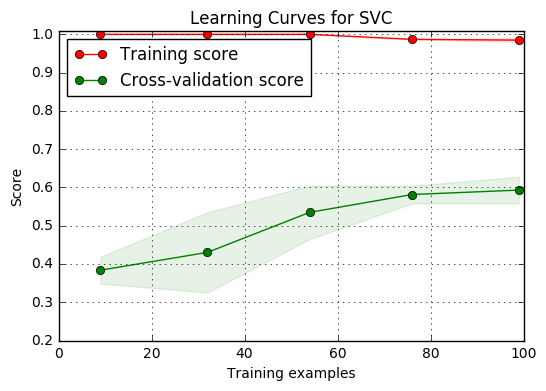

In [7]:
%matplotlib inline
from learning_curves import plot_learning_curve

title = "Learning Curves for SVC"
cv = ShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
plot_learning_curve(grid_result.best_estimator_, title, X, y, (0.2, 1.01), cv=cv, n_jobs=1).show()